In [168]:
import numpy as np
import time
import csv
import os
from sklearn.model_selection import train_test_split
import sklearn.utils
import math
import matplotlib.pyplot as plt
import struct

定义IRIS数据集类

In [169]:
class IrisDataset:
    def __init__(self,root='iris.csv'):
        self.root = root
        self.name = ['setosa','versicolor','virginica']
        self.data = self._load_data()
        a = 1

    def _load_data(self):
        if not os.path.isfile(self.root):
            raise()

        data = {}
        for i in range(len(self.name)):
            data[self.name[i]] = []
        with open(self.root,'r') as f:
            reader = csv.reader(f)
            reader.__next__()
            for row in reader:
                data[row[5]].append(list(map(float,row[1:-1])))

        return data

    ## used for training ovo classifier
    def split_data(self, ratio=0.2):
        '''
        Args:
            ratio: test_num / total_num
        '''
        train_data = []
        test_data = []
        for i in range(len(self.name)):
            data = self.data[self.name[i]]
            num_cls = len(data)
            num_test = int(num_cls * ratio)

            train_data.append(np.array(data[:-num_test]))
            test_data.append(np.array(data[-num_test:]))

            label = np.ones((num_cls-num_test,1)) * i
            train_data[i] = np.concatenate((train_data[i],label), axis=1)
            label = np.ones((num_test,1)) * i
            test_data[i] = np.concatenate((test_data[i],label), axis=1)

        return train_data, test_data

    ## used for training softmax classifier
    def get_data(self, ratio=0.2):
        label_num = [len(self.data[self.name[i]]) for i in range(len(self.name))]
        label = [i * np.ones((label_num[i],1)) for i in range(len(label_num))]
        label = np.concatenate(label)
        x = [self.data[self.name[i]] for i in range(len(self.name))]
        x = np.concatenate(x)

        train_x, test_x, train_y, test_y = train_test_split(x, label, test_size=ratio)

        return train_x, test_x, train_y, test_y


定义MNIST数据集

In [170]:
class MNIST(object):
    '''
    MNIST数据集类
    '''
    def __init__(self, root='./MNIST'):
        '''
        方法说明:
            初始化类
        参数说明:
            root: 文件夹根目录
            image_file: mnist图像文件 'train-images.idx3-ubyte' 'test-images.idx3-ubyte'
            label_file: mnist标签文件 'train-labels.idx1-ubyte' 'test-labels.idx1-ubyte'
        '''
        img_train_path = os.path.join(root, 'train-images.idx3-ubyte')
        label_train_path = os.path.join(root, 'train-labels.idx1-ubyte')
        img_test_path = os.path.join(root, 'test-images.idx3-ubyte')
        label_test_path = os.path.join(root, 'test-labels.idx1-ubyte')
        
        self.x_train = self._get_img(img_train_path)
        self.y_train = self._get_label(label_train_path)
        self.x_test = self._get_img(img_test_path)
        self.y_test = self._get_label(label_test_path)
        self.standardlize()

    #读取图片
    def _get_img(self, path):

        with open(path,'rb') as fi:
            ImgFile = fi.read()
            head = struct.unpack_from('>IIII', ImgFile, 0)
            #定位数据开始位置
            offset = struct.calcsize('>IIII')
            ImgNum = head[1]
            width = head[2]
            height = head[3]
            #每张图片包含的像素点
            pixel = height*width
            bits = ImgNum * width * height
            bitsString = '>' + str(bits) + 'B'
            #读取文件信息
            images = struct.unpack_from(bitsString, ImgFile, offset)
            #转化为n*726矩阵
            images = np.reshape(images,[ImgNum,pixel])
        
        return images.T

    #读取标签
    def _get_label(self, path):

        with open(path,'rb') as fl:
            LableFile = fl.read()
            head = struct.unpack_from('>II', LableFile, 0)
            labelNum = head[1]
            #定位标签开始位置
            offset = struct.calcsize('>II')
            numString = '>' + str(labelNum) + "B"
            labels = struct.unpack_from(numString, LableFile, offset)
            #转化为1*n矩阵
            labels = np.reshape(labels, [labelNum])

        return labels.reshape(-1,1)

    #数据标准化
    def normalize(self):
        
        min = np.min(self.x_train, axis=0).reshape(1,-1)
        max = np.max(self.x_train, axis=0).reshape(1,-1)
        self.x_train = (self.x_train - min)/(max - min)

        min = np.min(self.x_test, axis=0).reshape(1,-1)
        max = np.max(self.x_test, axis=0).reshape(1,-1)
        self.x_test = (self.x_test - min)/(max - min)

    #数据归一化
    def standardlize(self):
        
        mean = np.mean(self.x_train, axis=0).reshape(1,-1)
        var = np.var(self.x_train, axis=0).reshape(1,-1)
        self.x_train = (self.x_train-mean)/np.sqrt(var)

        mean = np.mean(self.x_test, axis=0).reshape(1,-1)
        var = np.var(self.x_test, axis=0).reshape(1,-1)
        self.x_test = (self.x_test-mean)/np.sqrt(var)

定义分类器模型 （1）基于PLA的one-versus-one的分类器 （2）softmax分类器

In [171]:
class PLA(object):
    def __init__(self, dimension):
        super(PLA,self).__init__()
        # zero initialization
        self.dimension = dimension
        self.W = np.zeros((1,dimension))
        self.b = 0
    
    def _update_param(self, x, y):
        self.W += x * y
        self.b += y

    def train(self, x, y):
        num, dim = x.shape
        if dim != self.dimension:
            raise
        optimized = False
        count = 0
        while not optimized:
            for i in range(num):
                if count == 1000:
                    optimized = True
                    break
                yhat = np.dot(self.W,x[i]) + self.b
                if yhat * y[i] <= 0:
                    self._update_param(x[i],y[i])
                    count += 1 
                    break
                # all data classify correctly
                if i == num-1:
                    optimized = True
        print('over training!')

    def predict(self, x, label=[0,1]):
        num, dim = x.shape
        if dim != self.dimension:
            raise
        yhat = np.matmul(self.W,x.transpose(1,0)) + self.b
        yhat = (np.sign(yhat).transpose(1,0))
        result = np.ones((num,1))
        result[np.where(yhat==1)[0]] = label[0]
        result[np.where(yhat==-1)[0]] = label[1]

        return result.astype(int)

    def eval(self, x, y):
        num, dim = x.shape
        if dim != self.dimension:
            raise
        yhat = np.matmul(self.W,x.transpose(1,0)) + self.b
        yhat = np.sign(yhat).transpose(1,0)
        accuracy = 1 - len(np.nonzero(yhat - y)[0])/len(y)
        print('accuracy: %.2f'%accuracy)

        return yhat

In [172]:
class Softmax:
    def __init__(self, cls_num=10, dimension=784):
        self.cls_num = cls_num
        self.dimension = dimension
        self.w = np.random.normal(0, 0.1, (cls_num,dimension+1)) ##增广化

    def train(self, x, y, lr=0.1, epoch=10, batchsize=256, log=False, shuffle=False):
        dimension, train_num = x.shape
        if not dimension == self.dimension:
            raise
        expand_dim = np.ones((1,train_num))
        x = np.concatenate((expand_dim,x),axis=0)

        iteration = math.ceil(train_num / batchsize)
        losses = np.zeros(epoch)
        acc = np.zeros(epoch)
        for n_epoch in range(epoch):
            if shuffle:
                x, y = sklearn.utils.shuffle(x.T, y, random_state=1)
                x, y = x.T, y
            for n_iteration in range(iteration):
                start = n_iteration * batchsize
                end = min((n_iteration + 1) * batchsize, train_num)
                x_iter = x[:,start:end]
                y_iter = y[start:end]

                yhat = self.softmax(np.matmul(self.w,x_iter))
                loss = self.cross_entropy(y_iter, yhat)
                losses[n_epoch] += loss

                grad = self._calculate_grad(x_iter, yhat, y_iter)
                self.w -= lr*grad

                yhat = np.argmax(yhat,axis=0).reshape(-1,1)
                accuracy = len(np.where(y_iter==yhat)[0]) / (end-start)
                acc[n_epoch] += accuracy
                
                if log:
                    print('epoch %i/%i iteration %i/%i loss %.2f accuracy %.2f'%
                                                (n_epoch,epoch,n_iteration,iteration,loss,accuracy))
            
            losses[n_epoch] /= iteration
            acc[n_epoch] /= iteration

        return losses, acc

    def predict(self, x):
        dimension, train_num = x.shape
        if not dimension == self.dimension:
            raise
        expand_dim = np.ones((1,train_num))
        x = np.concatenate((expand_dim,x),axis=0)

        yhat = self.softmax(np.matmul(self.w,x))
        yhat = np.argmax(yhat,axis=0)
        return yhat

    def _calculate_grad(self, x, yhat, y):
        dimension, batchsize = x.shape
        temp = yhat.copy()
        for i in range(batchsize):
            temp[y[i],i] -= 1
        grad = np.matmul(temp, x.T)/batchsize

        return grad

    def cross_entropy(self, y, yhat):
        loss = 0
        batchsize = y.shape[0]
        seq = np.arange(batchsize)
        b = yhat.T[seq,y.T]
        a = -np.log(yhat.T[seq,y.T])
        loss = np.sum(-np.log(yhat.T[seq,y.T]),axis=1)/batchsize

        return loss


    def softmax(self, x):
        exp = np.exp(x)
        exp_sum = np.sum(exp, axis=0)
        x = exp / exp_sum
        return x

首先加载数据集

In [173]:
root = 'iris.csv'
dataset = IrisDataset(root)
train_data, test_data = dataset.split_data(ratio=0.2)

print('类别: {}'.format(dataset.name))

类别: ['setosa', 'versicolor', 'virginica']


1 首先训练基于PLA的ovo算法分类器

定义训练函数

In [174]:
def train_ovo_classifier(model, data1, data2):
    data1[:,4] = 1
    data2[:,4] = -1
    x = np.concatenate((data1[:,:-1],data2[:,:-1]),axis=0)
    y = np.concatenate((data1[:,-1],data2[:,-1]),axis=0)
    model.train(x,y)
    return model

定义结果投票函数

In [175]:
def vote_ensemble_pred(model1, model2, model3, data):
    '''
    ovo vote ensemble
    '''
    data1 = np.array(data[0])
    data2 = np.array(data[1])
    data3 = np.array(data[2])
    x = np.concatenate([data1[:,:-1], data2[:,:-1], data3[:,:-1]],axis=0)
    y = np.concatenate([data1[:,-1], data2[:,-1], data3[:,-1]],axis=0)
    ## 三个二分类器分别计算
    y1 = model1.predict(x, label=[0,1])
    y2 = model2.predict(x, label=[0,2])
    y3 = model3.predict(x, label=[1,2])
    y_pred = np.concatenate((y1,y2,y3),axis=1)
    yhat = np.array([np.argmax(np.bincount(y_pred[k])) for k in range(y.shape[0])]).reshape(-1,1)
    
    return y.reshape(-1,1), yhat.reshape(-1,1)

In [176]:
## 定义三个分类器
classifier1 = PLA(dimension=4)
classifier2 = PLA(dimension=4)
classifier3 = PLA(dimension=4)

## 分别训练
classifier1 = train_ovo_classifier(classifier1, train_data[0], train_data[1])
classifier2 = train_ovo_classifier(classifier2, train_data[0], train_data[2])
classifier3 = train_ovo_classifier(classifier3, train_data[1], train_data[2])

## 打印参数值
print('classifier1 w: {} b: {}'.format(classifier1.W,classifier1.b))
print('classifier2 w: {} b: {}'.format(classifier2.W,classifier2.b))
print('classifier3 w: {} b: {}'.format(classifier3.W,classifier3.b))

over training!
over training!
over training!
classifier1 w: [[ 1.3  4.1 -5.2 -2.2]] b: 1.0
classifier2 w: [[ 2.7  3.9 -7.8 -4.4]] b: 1.0
classifier3 w: [[  95.3   62.2  -97.5 -159.7]] b: 10.0


性能测试

In [177]:
y, yhat = vote_ensemble_pred(classifier1, classifier2, classifier3, test_data)
correct = len(np.where(y==yhat)[0])

print('y: {}'.format(y.astype(int).flatten()))
print('yhat: {}'.format(yhat.flatten()))
print('accuracy: %.2f %%'%(correct*100/y.shape[0]))

y: [0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2]
yhat: [0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2]
accuracy: 100.00 %


2 训练softmax分类器

划分样本集

In [178]:
train_x, test_x, train_y, test_y = dataset.get_data()
train_x, test_x = train_x.T, test_x.T
train_y = train_y.astype(int)
test_y = test_y.astype(int)

print('train x: {}'.format(train_x.shape))
print('train y: {}'.format(train_y.shape))
print('test x: {}'.format(test_x.shape))
print('test y: {}'.format(test_y.shape))

train x: (4, 120)
train y: (120, 1)
test x: (4, 30)
test y: (30, 1)


定义分类器

In [179]:
classifier = Softmax(cls_num=3, dimension=4)

print('classifier.w: {}'.format(classifier.w.shape))
print(classifier.w)

classifier.w: (3, 5)
[[ 0.0546122  -0.01158904  0.06877576 -0.14928958  0.01345597]
 [-0.12124341  0.0180578  -0.05063262 -0.09429222  0.04131523]
 [-0.09914263 -0.02576496  0.09850732  0.03365589 -0.02210027]]


训练后结果
classifier.w: (3, 5)
[[ 0.21421892  0.30365971  0.86474011 -1.28639547 -0.50405452]
 [-0.0235602   0.23310176 -0.29749593  0.09340939 -0.15148446]
 [-0.35643256 -0.55605767 -0.45059371  0.98306017  0.68820991]]


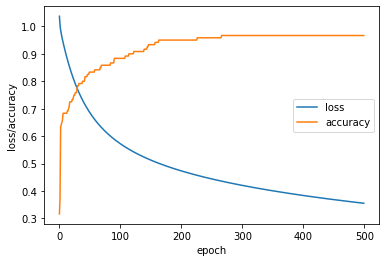

In [180]:
lr = 0.02
epoch = 500
batchsize = 120

loss, acc = classifier.train(train_x, train_y, lr=lr, epoch=epoch, batchsize=batchsize)

print('训练后结果')
print('classifier.w: {}'.format(classifier.w.shape))
print(classifier.w)

iteration = np.arange(len(loss))
plt.plot(iteration, loss, label='loss')
plt.plot(iteration, acc, label='accuracy')
plt.xlabel('epoch')
plt.ylabel('loss/accuracy')
plt.legend(loc='best')
plt.show()

测试其在测试集上准确率

In [181]:
yhat = classifier.predict(test_x).reshape(-1,1)

correct = len(np.where(test_y==yhat)[0])
print('准确率: %.2f %%'%(correct*100/y.shape[0]))

准确率: 100.00 %


3 用softmax分类MNIST数据集

In [182]:
mnist = MNIST()
mnist.normalize()

x_train = mnist.x_train
y_train = mnist.y_train
x_test = mnist.x_test
y_test = mnist.y_test

print('x_train {}'.format(x_train.shape))
print('y_train {}'.format(y_train.shape))
print('x_test {}'.format(x_test.shape))
print('y_test {}'.format(y_test.shape))

x_train (784, 60000)
y_train (60000, 1)
x_test (784, 10000)
y_test (10000, 1)


epoch 0/10 iteration 0/235 loss 2.54 accuracy 0.16
epoch 0/10 iteration 1/235 loss 2.66 accuracy 0.14
epoch 0/10 iteration 2/235 loss 2.58 accuracy 0.12
epoch 0/10 iteration 3/235 loss 2.55 accuracy 0.14
epoch 0/10 iteration 4/235 loss 2.56 accuracy 0.15
epoch 0/10 iteration 5/235 loss 2.52 accuracy 0.11
epoch 0/10 iteration 6/235 loss 2.46 accuracy 0.16
epoch 0/10 iteration 7/235 loss 2.54 accuracy 0.14
epoch 0/10 iteration 8/235 loss 2.47 accuracy 0.15
epoch 0/10 iteration 9/235 loss 2.41 accuracy 0.18
epoch 0/10 iteration 10/235 loss 2.44 accuracy 0.17
epoch 0/10 iteration 11/235 loss 2.34 accuracy 0.19
epoch 0/10 iteration 12/235 loss 2.44 accuracy 0.12
epoch 0/10 iteration 13/235 loss 2.39 accuracy 0.15
epoch 0/10 iteration 14/235 loss 2.36 accuracy 0.21
epoch 0/10 iteration 15/235 loss 2.41 accuracy 0.19
epoch 0/10 iteration 16/235 loss 2.34 accuracy 0.20
epoch 0/10 iteration 17/235 loss 2.35 accuracy 0.18
epoch 0/10 iteration 18/235 loss 2.30 accuracy 0.19
epoch 0/10 iteration 1

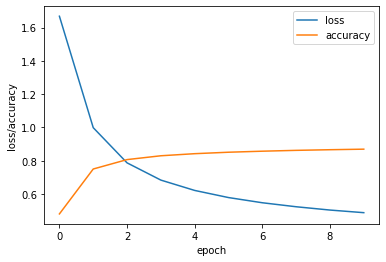

In [185]:
lr = 0.01
epoch = 10
batchsize = 256

classifier = Softmax()
loss, acc = classifier.train(x_train, y_train, lr=lr, epoch=epoch, batchsize=batchsize, log=True, shuffle=True)

iteration = np.arange(len(loss))
plt.plot(iteration, loss, label='loss')
plt.plot(iteration, acc, label='accuracy')
plt.xlabel('epoch')
plt.ylabel('loss/accuracy')
plt.legend(loc='best')
plt.show()

使用测试集测试性能

In [186]:
yhat = classifier.predict(x_test).reshape(-1,1)
correct = len(np.where(y_test==yhat)[0])
print('准确率: %.2f %%'%(correct*100/y_test.shape[0]))

准确率: 87.86 %


可视化模型预测结果

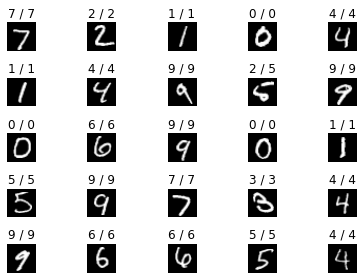

In [206]:
for i in range(25):
    plt.subplot(5, 5, i+1)
    plt.title('%i / %i'%(yhat[i],y_test[i]))
    plt.imshow(x_test[:,i].reshape(28,28),cmap='gray')
    plt.axis('off')
plt.tight_layout()
plt.show()